# Homework 4 - PCA & Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
air_data = pd.read_csv("air_data_utf8.csv", encoding="utf-8")
passeneger_data = pd.read_csv("Airline_Passenger_Satisfaction.csv")

air_df = air_data.copy()
passenger_df = passeneger_data.copy()

In [15]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MEMBER_NO                62988 non-null  int64  
 1   FFP_DATE                 62988 non-null  object 
 2   FIRST_FLIGHT_DATE        62988 non-null  object 
 3   GENDER                   62985 non-null  object 
 4   FFP_TIER                 62988 non-null  int64  
 5   WORK_CITY                60719 non-null  object 
 6   WORK_PROVINCE            59740 non-null  object 
 7   WORK_COUNTRY             62962 non-null  object 
 8   AGE                      62568 non-null  float64
 9   LOAD_TIME                62988 non-null  object 
 10  FLIGHT_COUNT             62988 non-null  int64  
 11  BP_SUM                   62988 non-null  int64  
 12  EP_SUM_YR_1              62988 non-null  int64  
 13  EP_SUM_YR_2              62988 non-null  int64  
 14  SUM_YR_1              

In [14]:
passenger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

# **Task 1. 对两个数据做描述性统计分析**

## 1.1 air_data.csv: 航空公司客户信息的统计数据

In [34]:
# 删除票价为空或为0的数据
air_info = air_df.dropna(subset=['SUM_YR_1', 'SUM_YR_2'])
air_info = air_info[air_info['SUM_YR_1'] != 0]
air_info = air_info[air_info['SUM_YR_2'] != 0]

# 处理workprovince & work city
air_info.drop(columns=["WORK_PROVINCE", "WORK_CITY"],
              inplace=True)

# 处理age列的空值
air_info["AGE"] = air_info['AGE'].fillna(
                value=air_df['AGE'].mean())

# 处理 WORK_COUNTRY
air_info["WORK_COUNTRY"] = air_info["WORK_COUNTRY"].fillna(
                                method="backfill"
                            )
         
# 处理gender
air_info = air_info.dropna(subset=['GENDER'])

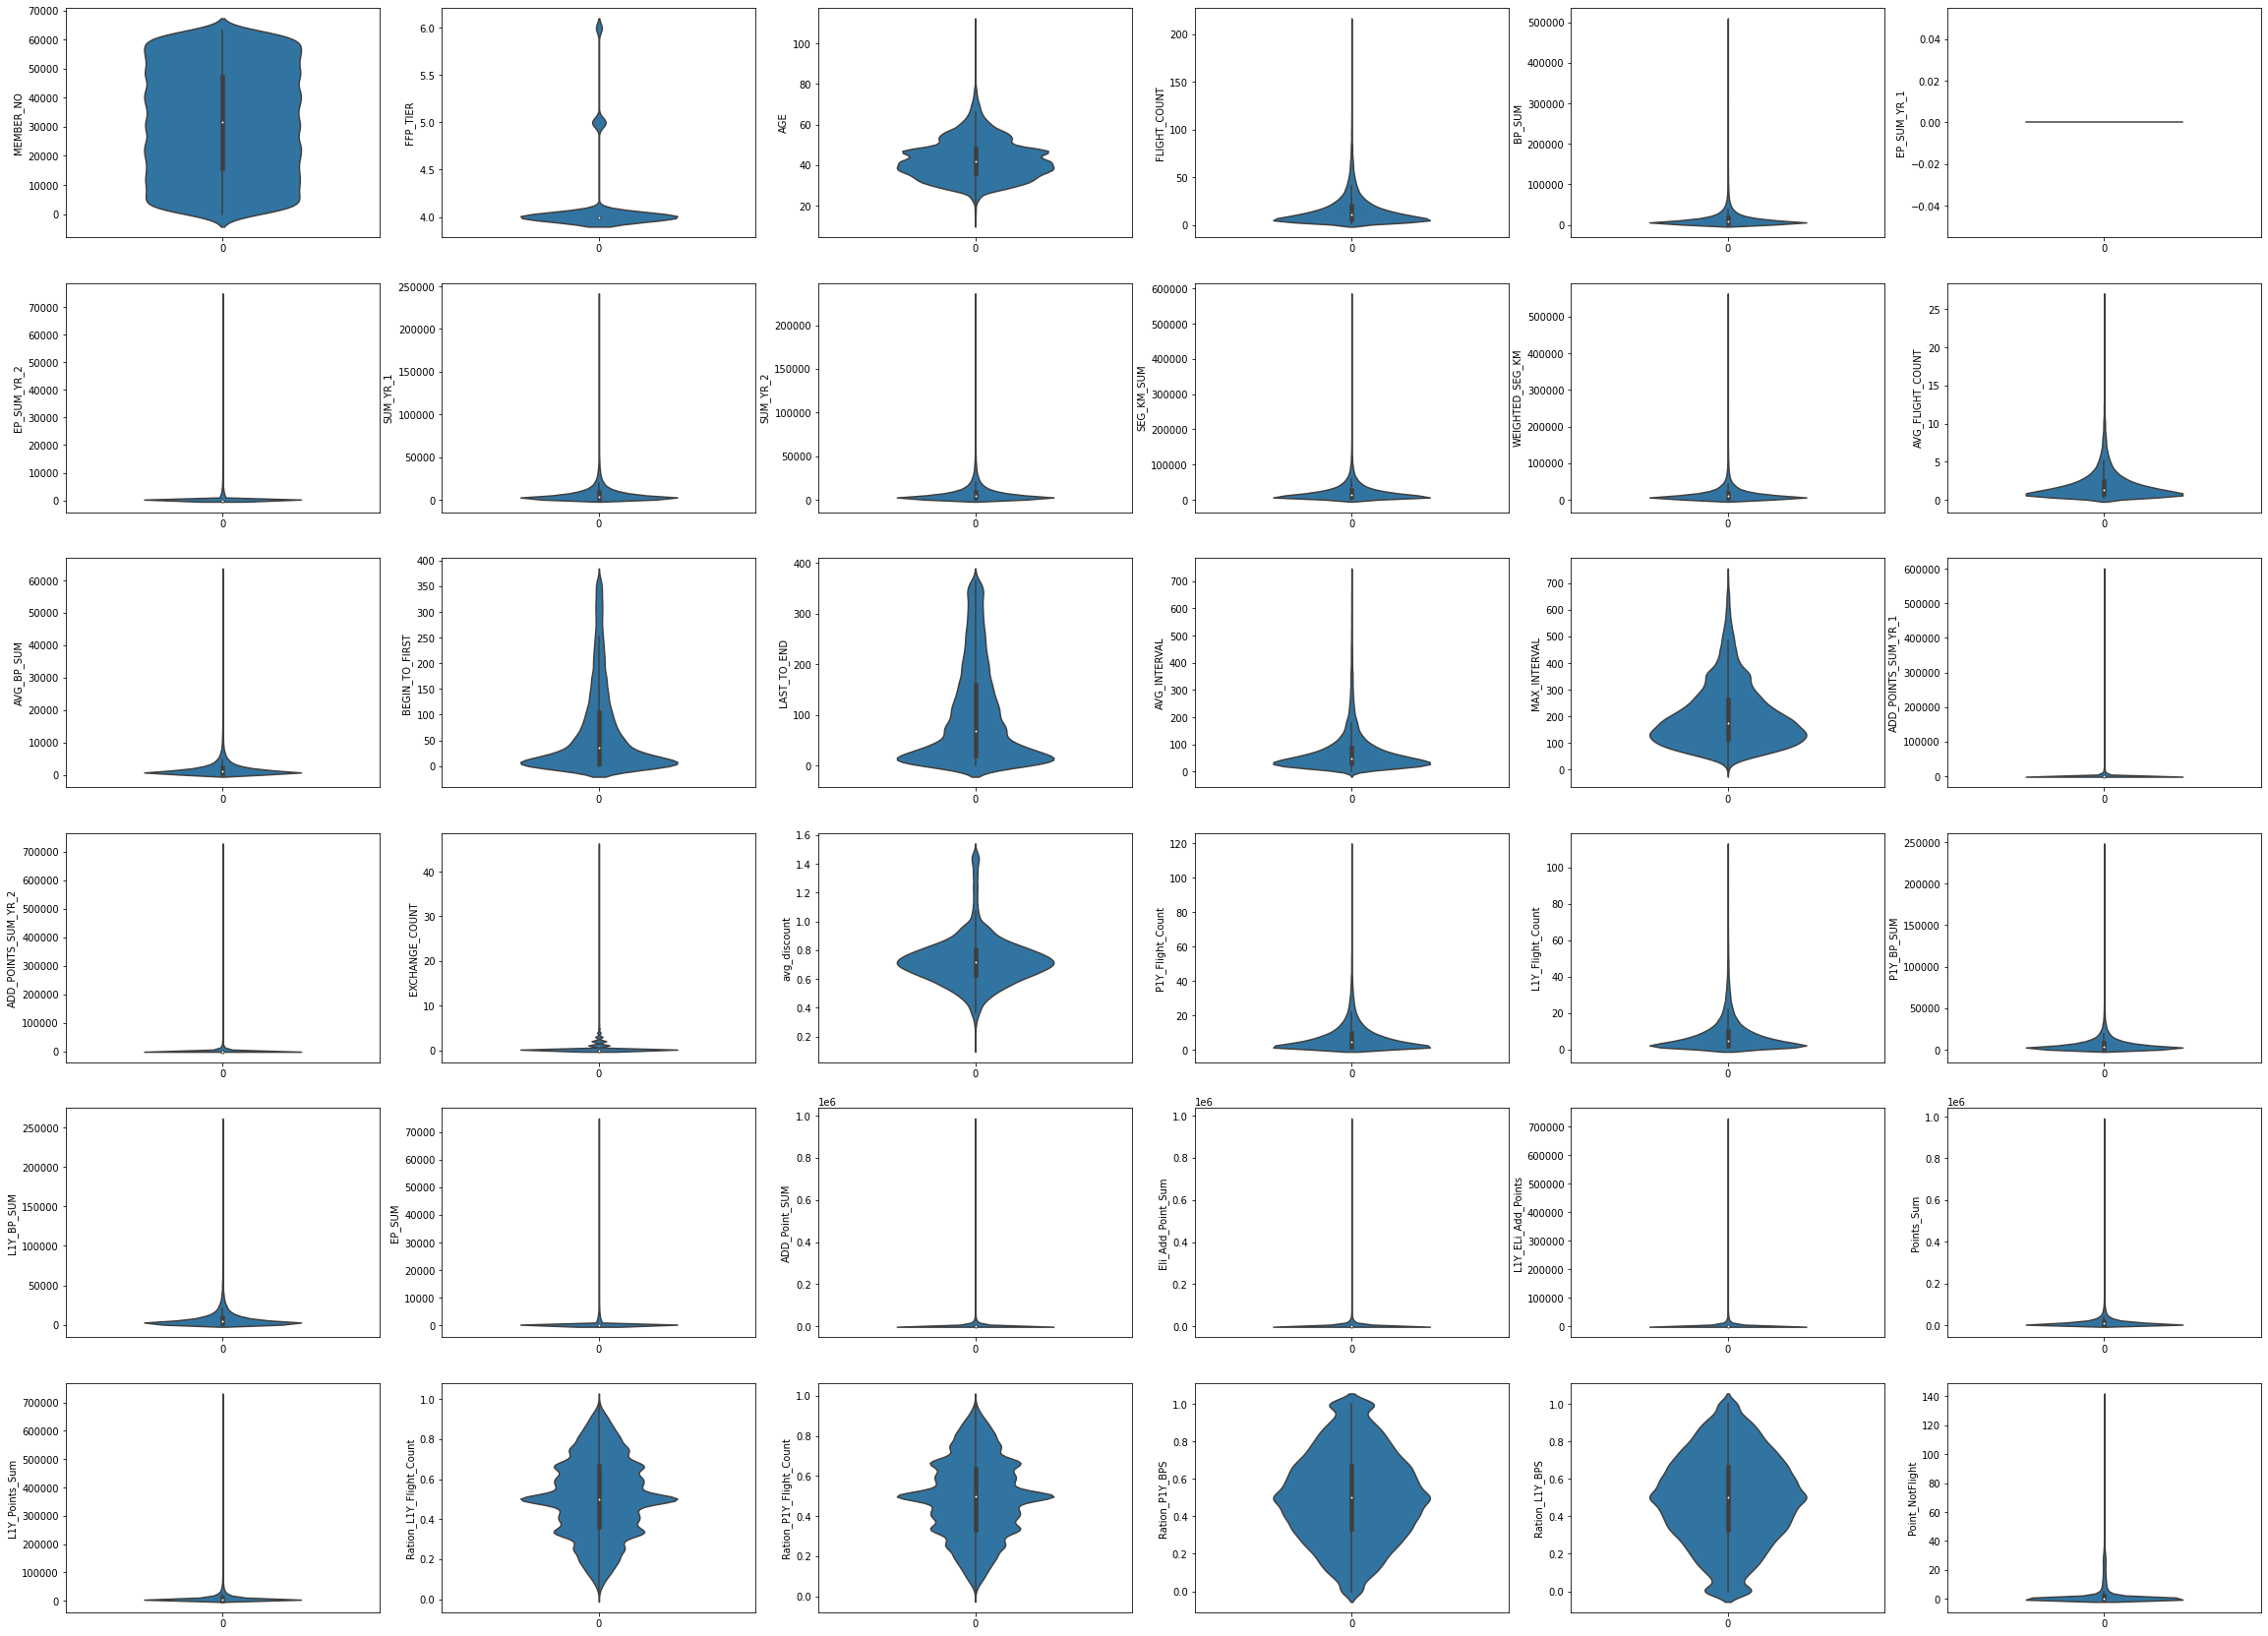

In [87]:
# 数值型数据 - 绘制小提琴图
def _numerical(col):
    if air_info[col].dtype != 'object':
        return col

numerical = list(filter(None, [_numerical(col) 
                   for col in air_info.columns]))

plt.figure(figsize=(40,30))
for i in range(len(numerical)):
    _ = plt.subplot(6, 6, i+1)
    _ = sns.violinplot(data = air_info[numerical[i]],orient='v', width=0.5)
    _ = plt.ylabel(numerical[i])
plt.show()

## 1.2 Airline_Passenger_Satisfaction.csv: 客户满意度调查

In [89]:
# 删除无用数据
passenger_df.drop(columns=['Unnamed: 0', 'id'], inplace=True)

# 填充数据
passenger_df["Arrival Delay in Minutes"].fillna(
    value = passenger_df["Arrival Delay in Minutes"].mean(),
    inplace=True)

In [96]:
# 数值型数据 - 绘制小提琴图
def _cls(col):
    if passenger_df[col].dtype == 'object':
        return col
    
def _numerical(col):
    if passenger_df[col].dtype != 'object':
        return col

cls_info = list(filter(None, [_cls(col) 
                   for col in passenger_df.columns]))

numerical = list(filter(None, [_numerical(col) 
                   for col in passenger_df.columns]))

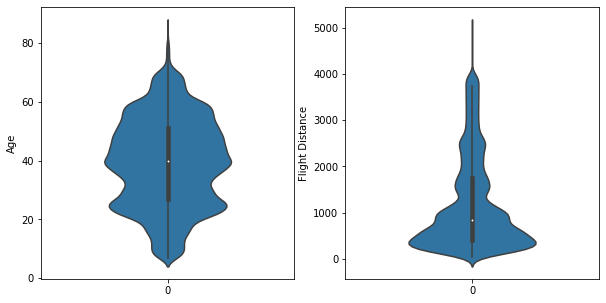

In [104]:
plt.figure(figsize=(10,5))
for i in range(len(numerical[:2])):
    _ = plt.subplot(1, 2, i+1)
    _ = sns.violinplot(data = passenger_df[numerical[i]],orient='v', width=0.5)
    _ = plt.ylabel(numerical[i])
plt.show()

In [138]:
temp_data[temp_col[0]].unique()

array([3, 2, 4, 1, 5, 0], dtype=int64)

In [142]:
temp_data[temp_data[temp_col[0]] == 3]

0          True
1          True
2         False
3         False
4          True
          ...  
103899    False
103900    False
103901    False
103902    False
103903    False
Name: Inflight wifi service, Length: 103904, dtype: bool

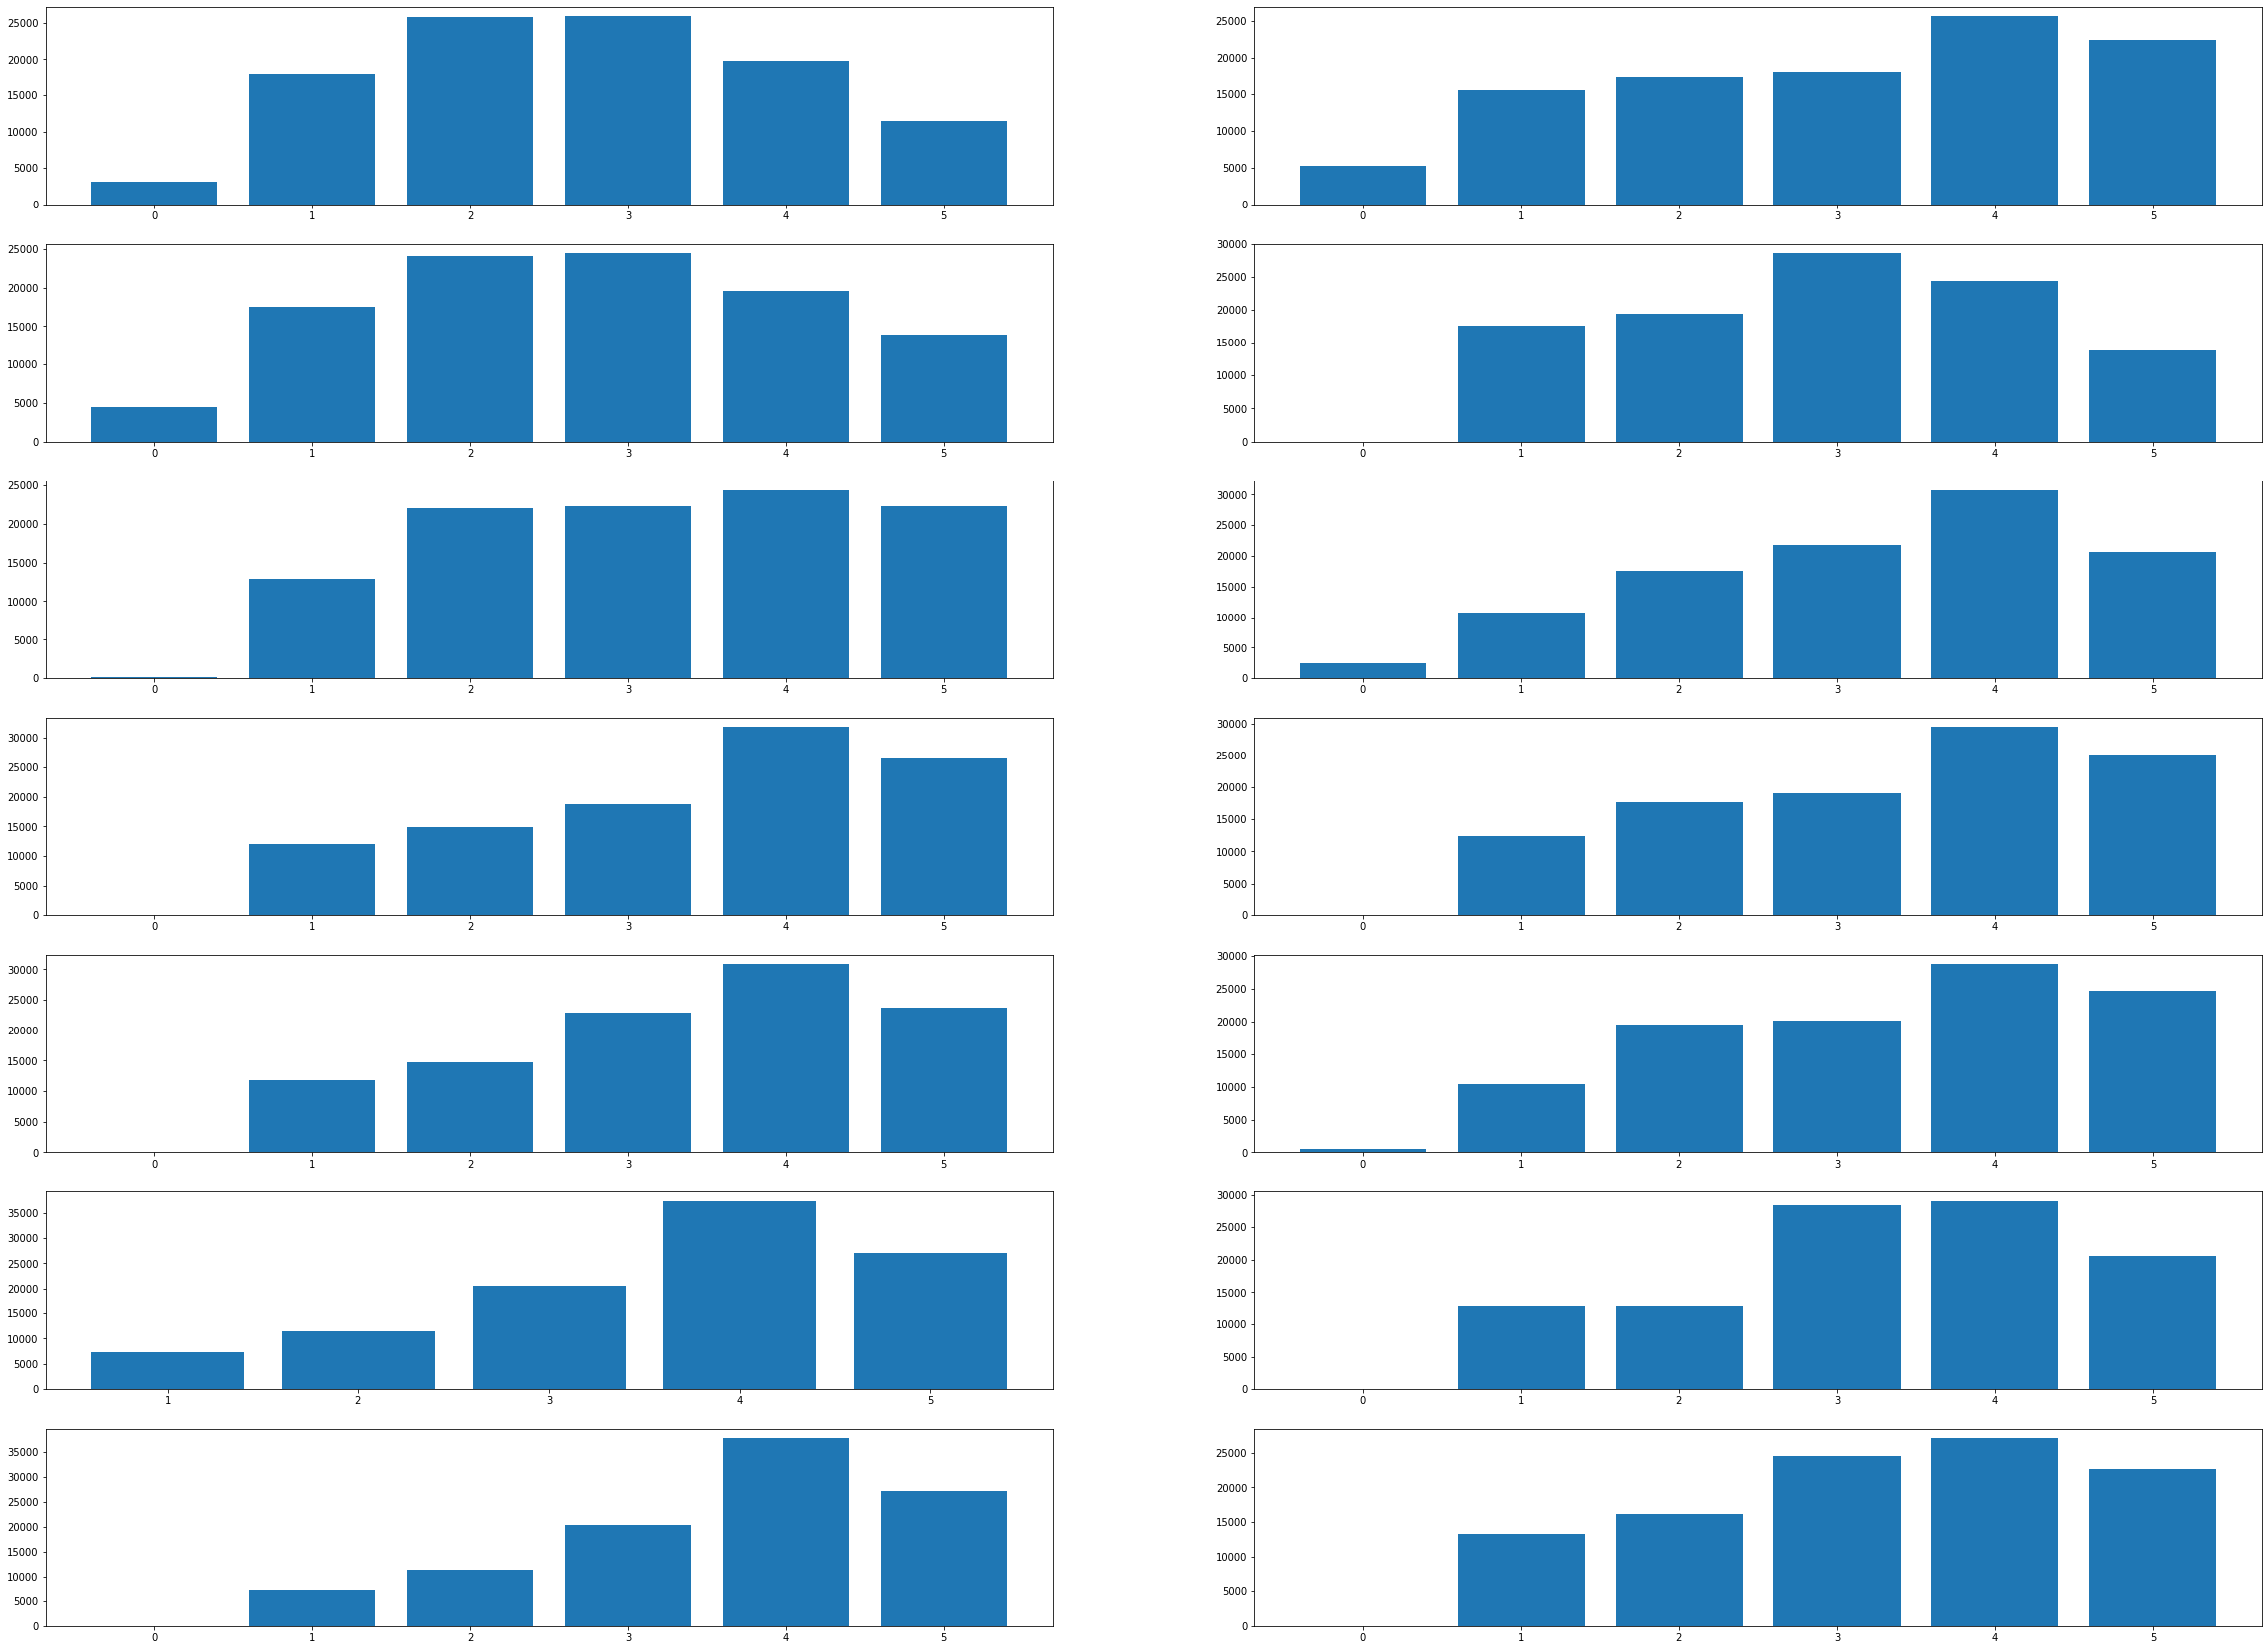

In [147]:
# 满意度描述性统计分析
temp_col = numerical[2:-2]
temp_data = passenger_df[temp_col]

plt.figure(figsize=(40,30))
for i in range(len(temp_col)):
    plt.subplot(7, 2, i+1)
    x_data = temp_data[temp_col[i]].unique()
    y_data = []
    for each in x_data:
        tmp = len(temp_data[temp_data[temp_col[i]] == each])
        y_data.append(tmp)
    plt.bar(x_data, y_data)
plt.show()

- 不满意的乘客比满意的多；
- 各个服务评价总体较高

# 2. 对Airline_Passenger_Satisfaction.csv的特征进行主成分分析和因子分析，及其对“航空公司满意度水平”的影响。解释分析结果。

In [148]:
from sklearn.preprocessing import StandardScaler

In [204]:
# 转换类别变量 - 只使用评价相关的列
passenger_info = pd.get_dummies(passenger_df[passenger_df.columns[6:-1]])
# 数据scale缩放
scaler = StandardScaler()
passenger_data = scaler.fit_transform(passenger_info)

### **2.1 PCA**

In [211]:
'''PCA主成分分析'''
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
passenger_data_pca = pca.fit_transform(passenger_data)
print("Origin shape:{};\nAfter PCA: {}".format(passenger_data.shape, passenger_data_pca.shape))

Origin shape:(103904, 16);
After PCA: (103904, 2)


<AxesSubplot:>

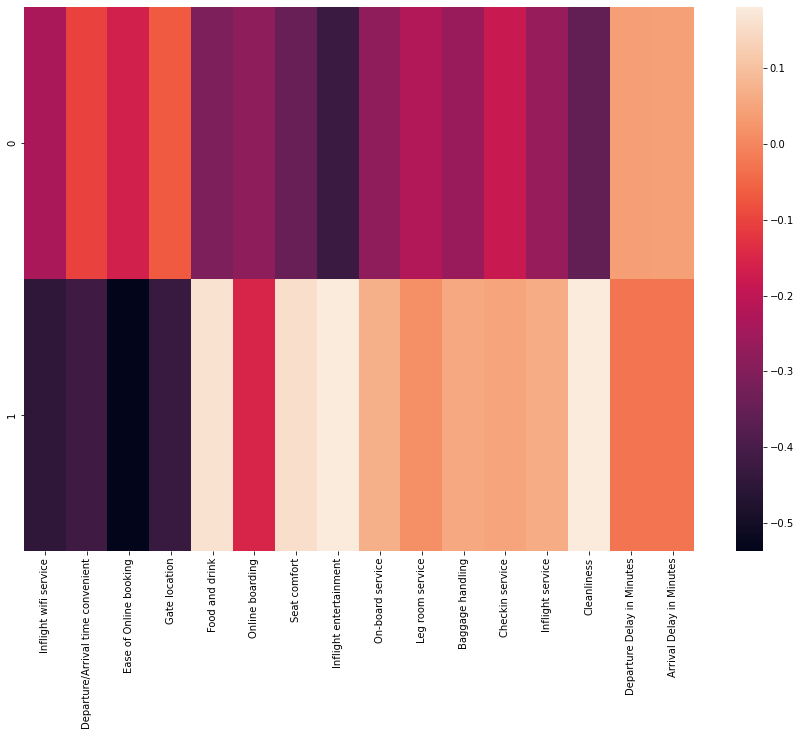

In [210]:
# 热图和颜色栏基本上表示各特征与主成分本身之间的相关性。
tmp = pd.DataFrame(pca.components_,columns=passenger_info.columns)
plt.figure(figsize=(15,10))
sns.heatmap(tmp)

**结论**
- 起飞时间 与 到达时间的延误与主成分的相关性较高：会一定程度上影响用户的满意度
- 食物饮料 & 座椅舒适度 & 机上娱乐 & 整洁程度：这几项也在一定程度上影响了客户的满意度
- 所以，需要在上述几个项目上进行改进

### **2.2 因子分析**

In [219]:
from factor_analyzer import FactorAnalyzer
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings("ignore")

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

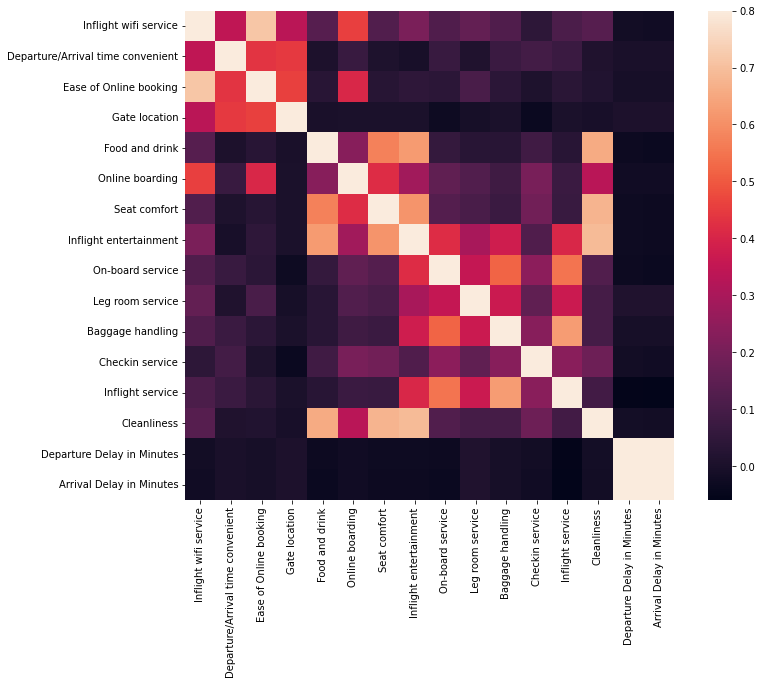

In [216]:
'''
多重共线性
- 结果：多个特征之间的相关性较高，如（Departure_Delay_in_Minutes & Arrival_Delay_in_Minutes）
'''
corrmat = passenger_info.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [221]:
'''
两个检验
(Bartlett's球状检验, kmo检验)
Bartlett's球状检验是一种数学术语。用于检验相关阵中各变量间的相关性，是否为单位阵，即检验各个变量是否各自独立。
- 结果：KMO值大于0.6,意味着变量间的相关性强，原有变量越适合作因子分析,一般认为KMO>0.6可采用因子分析；
'''
# 1. Bartlett's球状检验
chi_square_value, p_value = calculate_bartlett_sphericity(passenger_data)
print(chi_square_value,p_value)

# 2. kmo检验 （输出大于0.6故通过检验）
kmo_all, kmo_model = calculate_kmo(passenger_data)
print(kmo_model)

870046.690610317 0.0
0.7347692053597762


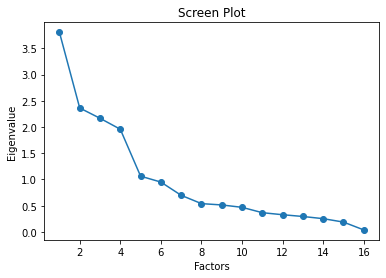

In [232]:
'''
选择合适的因子个数
结果：根据可视化，选6个
'''
fa = FactorAnalyzer(16,rotation=None)
fa.fit(passenger_data)
ev,v = fa.get_eigenvalues()

# 可视化
_ = plt.scatter(range(1,passenger_data.shape[1]+1),ev) # scatter横轴是指标个数，纵轴是特征值
_ = plt.plot(range(1,passenger_data.shape[1]+1),ev) # plot横轴是指标个数，纵轴是特征值
_ = plt.title('Screen Plot')
_ = plt.xlabel('Factors')
_ = plt.ylabel('Eigenvalue')
plt.show()

Text(86.99999999999999, 0.5, 'Sepal Width')

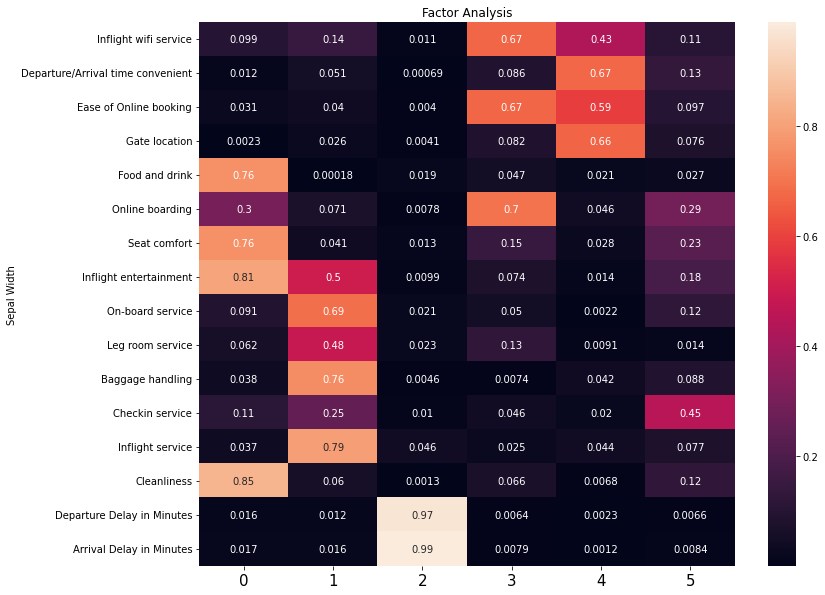

In [239]:
'''
因子分析
'''
fa = FactorAnalyzer(6, rotation="varimax")
fa.fit(passenger_data)

# 对因子分析结果进行可视化。
tmp = pd.DataFrame(np.abs(fa.loadings_),index=passenger_info.columns)
plt.figure(figsize=(12,10))
sns.heatmap(tmp,annot=True)
# 设置y轴字体的大小
plt.tick_params(axis='x',labelsize=15)
plt.title("Factor Analysis",fontsize=12)
plt.ylabel("Sepal Width")

**结论**
- 起飞和降落延误对用户满意度带来较大影响
- 整洁度、机上服务、行李处理、座椅舒适、机上餐饮、在线登机等，一定程度上会影响用户满意度

# 3.至少使用两种聚类方法对air_data.csv进行聚类分析，并比较各方法的异同.

### **3.1 KMeans**

In [275]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=2,random_state=17).fit(passenger_data) #使用因子分析后的数据

y_pred = cluster.labels_ # 获取聚类结果
centers = cluster.cluster_centers_ # 获取质心
inertia = cluster.inertia_ # 查看簇内平方和

print(y_pred)
print(centers)
print(inertia)

[0 1 0 ... 0 1 1]
[[ 0.26437034  0.0716402   0.14735478  0.02115378  0.4939495   0.38229235
   0.54737127  0.68368996  0.38883818  0.2988415   0.3572604   0.24741087
   0.36529796  0.57446023 -0.05500018 -0.05851292]
 [-0.33165751 -0.08987396 -0.18485932 -0.02653781 -0.61966885 -0.47959288
  -0.68668745 -0.85770179 -0.48780473 -0.37490222 -0.44818983 -0.31038155
  -0.45827309 -0.72067105  0.06899876  0.07340554]]
1381741.399786335


In [276]:
# 4.聚类结果可视化
pca = PCA(n_components=2) # 进行数据降维处理(以查看可视化结果)
pca.fit(passenger_data)
df = pd.DataFrame(pca.transform(passenger_data))
df['label'] = y_pred

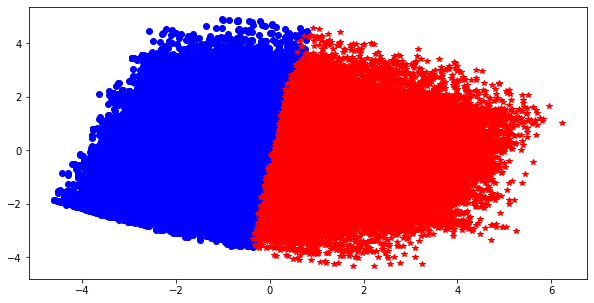

In [277]:
df0 = df[df['label'] == 0]
df1 = df[df['label'] == 1]

fig = plt.figure(figsize=(10,5))
plt.plot(df0[0],df0[1],'bo',
         df1[0],df1[1],'r*',
        )
plt.show()

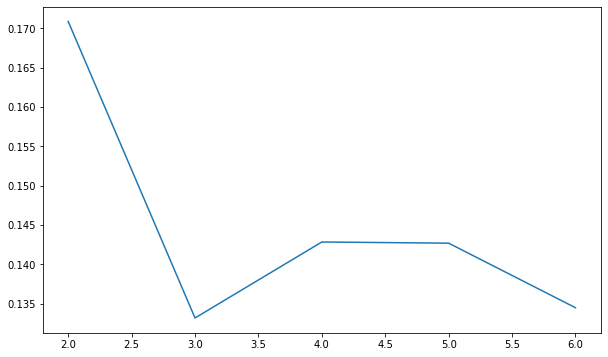

In [280]:
'''
5.评价指标

聚类评价指标分为：外部指标，聚类完成后将聚类结果与某个参考模型进行比较；内部指标，直接考察聚类结果而不利用任何参考模型
（1） 使用轮廓系数法评价K-Means聚类模型 --- 内部评价指标，畸变程度
'''
from sklearn.metrics import silhouette_score

silhouetteScore = []
for i in range(2,7):
    # 构建并训练模型
    kmeans = KMeans(n_clusters=i,random_state=17).fit(passenger_data)
    score = silhouette_score(passenger_data,kmeans.labels_)
    silhouetteScore.append(score)
    

# 作图
plt.figure(figsize=(10,6))
plt.plot(range(2,7),silhouetteScore,linewidth=1.5,linestyle='-')
plt.show()

**Kmeans算法的优点：**

- 容易理解，聚类效果不错，虽然是局部最优， 但往往局部最优就够了；
- 处理大数据集的时候，该算法可以保证较好的伸缩性；
- 当簇近似高斯分布的时候，效果非常不错；
- 算法复杂度低

**Kmeans算法的不足：**

- K 值需要人为设定，不同 K 值得到的结果不一样；
- 对初始的簇中心敏感，不同选取方式会得到不同结果；
- 对异常值敏感；
- 不适合太离散的分类、样本类别不平衡的分类、非凸形状的分类。

### **3.2 Minibatch KMeans**

**区别**

- 每次抽取一个Mini-batch的数据，并用KMeans算法得到聚类

In [286]:
from sklearn.cluster import MiniBatchKMeans

cluster = MiniBatchKMeans(n_clusters=2,random_state=17).fit(passenger_data) #使用因子分析后的数据

In [287]:
silhouette_score(passenger_data, cluster.labels_)

0.17050833270213506

In [ ]:
'''
层次聚类
 - 内存占用过大
'''
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import confusion_matrix

# #linkage代表计算类与类之间距离的方法,ward是层次聚类常用方法
# clustering = AgglomerativeClustering(linkage='ward', n_clusters=2)
# res = clustering.fit(passenger_data_pca)
 
# print ("各个簇的样本数目：")
# print (pd.Series(clustering.labels_).value_counts())
# print ("聚类结果：")
# print (confusion_matrix(iris.target, clustering.labels_))